# **Описание**
---

В этом тестовом задании предстояло **классифицировать** мобильные устройства **по степени внешнего состояния**

Всего было представлено **4 класса состояний** (по 50 изображений в каждом): 
* A
* B
* C
* D 

В качестве решения представлены **два варианта использования нейросетевых моделей** для задачи классификации:

* Fine-tuning **MobileNetV3-Small** (Accuracy = 1.0)
* Обучение с нуля небольшой **кастомной CNN** (Accuracy = 1.0)


In [1]:
!nvidia-smi

Thu Sep 15 13:17:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Загрузка и визуализация данных**
---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/photosets_collages.zip

Archive:  /content/drive/MyDrive/photosets_collages.zip
   creating: photosets_collages/
   creating: photosets_collages/A/
  inflating: photosets_collages/A/0479622e-752f-478b-ae48-38f04293e97c.jpg  
  inflating: photosets_collages/A/0ACE16FE-2F2D-4FC2-8484-33D4D64C1201.jpg  
  inflating: photosets_collages/A/0D0F51D6-7AF0-416A-874F-0081C35F7449.jpg  
  inflating: photosets_collages/A/0D5EF9D1-21FA-469B-94D4-ABDFD754483D.jpg  
  inflating: photosets_collages/A/12493093-7a8a-432f-8b7d-82cb9a9e6819.jpg  
  inflating: photosets_collages/A/151660b0-5de3-49db-850e-9bbe56846579.jpg  
  inflating: photosets_collages/A/1C20460A-8AEC-4891-AF89-DD14473F1D39.jpg  
  inflating: photosets_collages/A/1CB98969-0DEE-4827-BF90-29550CCDF0A6.jpg  
  inflating: photosets_collages/A/267411d0-8f09-4bb0-852c-5727e43bdc4a.jpg  
  inflating: photosets_collages/A/29589977-7ec3-49b7-bb6c-f28e2a974482.jpg  
  inflating: photosets_collages/A/30554711-7d53-42ac-98fa-a7f7b8449fbc.jpg  
  inflating: photosets_collag

In [4]:
# Загрузка зависимостей

import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch.nn as nn
import torch, torchvision
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm, trange
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from utils.class_score import  class_score
from utils.visualization import plot_loss, imshow

In [5]:
# Путь к датасету

DATASET_PATH = "/content/photosets_collages/"

In [6]:
RESCALE_SIZE = 256  # Все изображения будут масштабированы к размеру 256х256
DEVICE = torch.device("cuda") # Будем использовать GPU
NCATS = len(os.listdir(DATASET_PATH)) # Количество классов

In [7]:
def seed_worker(worker_id):
    np.random.seed(42)
    random.seed(42)

In [8]:
# Разделим исходный датасет на тренировочную и валидационную выборки в пропорции 0.8/0.2

FULL_DATASET = torchvision.datasets.ImageFolder(root=DATASET_PATH)

test_size = int(0.2 * len(FULL_DATASET))
test_set = torch.utils.data.Subset(FULL_DATASET, range(test_size)).dataset  # Валидационный набор
train_set = torch.utils.data.Subset(FULL_DATASET, range(test_size, len(FULL_DATASET))).dataset # Тренировочный набор

In [9]:
# Базовый набор аугментаций (использовать больше не потребовалось)

train_transforms = transforms.Compose([
                                 transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                 transforms.RandomHorizontalFlip(),                   
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


test_transforms = transforms.Compose([  
                                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Применим аугментации к наборам данных

train_set.transform = train_transforms 
test_set.transform = test_transforms

In [10]:
# Создадим DataLoader`ы для наборов данных с batch_size = 8

trainloader = DataLoader(train_set, batch_size = 8, shuffle=True, num_workers = 2, worker_init_fn=seed_worker)
testloader = DataLoader(test_set, batch_size = 8, shuffle=False, num_workers = 2, worker_init_fn=seed_worker)

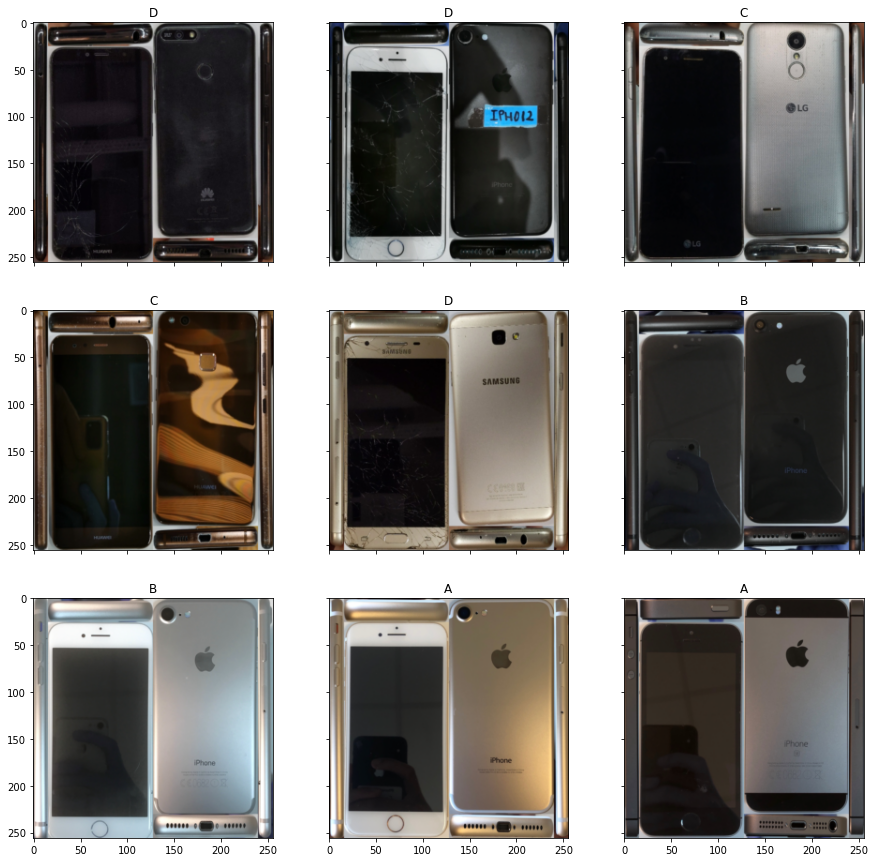

In [11]:
# Визуализация устройств и их классов

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)

train_size = len(train_set)

label_encoder = LabelEncoder().fit(train_set.classes)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, train_size))
    im_train, label = train_set[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), str(label_encoder.inverse_transform([label])[0]).split('_')))
    imshow(im_train.data.cpu(), plt_ax=fig_x, title=img_label)

In [12]:
# Тренировочный цикл

def train(train_loader, val_loader, model, num_epochs, optimizer, criterion, scheduler=None):

    best_model_wts = model.state_dict()
    best_epoch = 0
    best_score = 0
    
    
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    loaders = {"train": train_loader, "val": val_loader}

    for epoch in pbar:

        for k, dataloader in loaders.items():

            running_loss = 0.0
            epoch_preds, epoch_batches = [], []

            for batch in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch, y_batch = batch
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                if k == "train":
                    model.train()  
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()  
                    optimizer.step()  
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)

                preds = outp.argmax(-1)

                epoch_preds += preds.cpu()
                epoch_batches += y_batch.cpu()
                running_loss += loss.item() * x_batch.size(0)

            epoch_score = accuracy_score(epoch_preds, epoch_batches)
            epoch_loss = running_loss / len(dataloader.dataset)
            losses[k].append(epoch_loss)

  
            
            if k == 'val': 
              print(f'Epoch: {epoch + 1} of {num_epochs}  Score: {epoch_score}')
              if scheduler is not None:
                scheduler.step(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Score: {:.4f}'.format(k, epoch_loss, epoch_score))

            if k == 'val' and epoch_score > best_score:
               best_score = epoch_score
               best_epoch = epoch + 1
               best_model_wts = model.state_dict()
      
                
            
    print(f'Best score: {best_score}\nEpoch {best_epoch} of {num_epochs}')
    model.load_state_dict(best_model_wts)
    return model, losses, best_score

# **MobileNetV3-Small Fine-tuning**
---

In [13]:
torch.cuda.empty_cache()

In [14]:
mob_netv3 = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [15]:
# Т.к. сеть имеет веса с imagenet, то добавим один слой для уменьшения выходных классов до 4

mob_netv3.fc = nn.Linear(1024, NCATS)

In [16]:
mob_netv3 = mob_netv3.to(DEVICE)

In [17]:
# Fine-tuning - 15 эпох

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mob_netv3.parameters(), lr=1e-4, weight_decay = 1e-5) # Adam с L2-регуляризацией 

mob_netv3, losses_mob_netv3, accuracy_mob_netv3 = train(trainloader,testloader, model=mob_netv3, num_epochs=15, optimizer=optimizer, criterion=criterion)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 of 15  Score: 0.015


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2 of 15  Score: 0.275


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3 of 15  Score: 0.445


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4 of 15  Score: 0.6


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5 of 15  Score: 0.74


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6 of 15  Score: 0.79


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7 of 15  Score: 0.82


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8 of 15  Score: 0.905


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9 of 15  Score: 0.91


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 of 15  Score: 0.96


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11 of 15  Score: 0.97


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 of 15  Score: 0.99


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13 of 15  Score: 0.99


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14 of 15  Score: 1.0


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 of 15  Score: 1.0
Best score: 1.0
Epoch 14 of 15


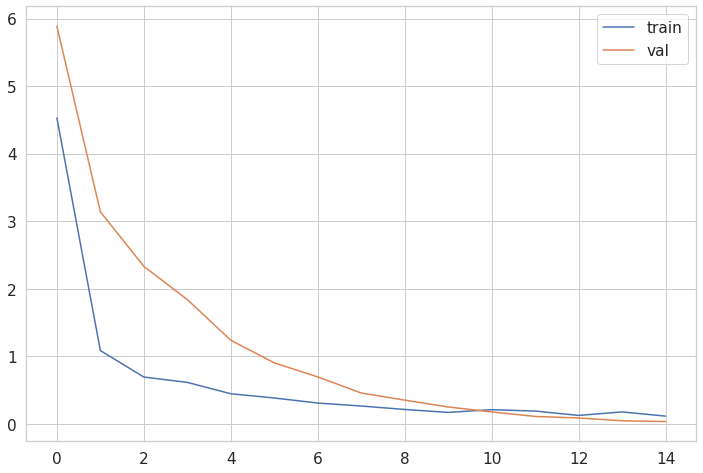

In [18]:
# Визуализируем train / val loss

plot_loss(losses_mob_netv3)

In [19]:
# Сохраним результат

torch.save(mob_netv3.state_dict(), '/content/mob_netv3.pth')

# **Custom CNN training**
---

In [23]:
torch.cuda.empty_cache()

In [24]:
from custom_cnn import Custom_CNN

custom_cnn = Custom_CNN().to(DEVICE)

In [25]:
# Обучение CNN - 25 эпох

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(custom_cnn.parameters(), lr=1e-3) # AdamW

custom_cnn, losses_custom_cnn, accuracy_custom_cnn = train(trainloader, testloader, model=custom_cnn, num_epochs=25, optimizer=optimizer, criterion=criterion)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 of 25  Score: 0.435


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2 of 25  Score: 0.515


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3 of 25  Score: 0.64


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4 of 25  Score: 0.685


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5 of 25  Score: 0.68


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6 of 25  Score: 0.77


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7 of 25  Score: 0.85


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8 of 25  Score: 0.83


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9 of 25  Score: 0.89


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 of 25  Score: 0.875


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11 of 25  Score: 0.875


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 of 25  Score: 0.92


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13 of 25  Score: 0.905


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14 of 25  Score: 0.895


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 of 25  Score: 0.91


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16 of 25  Score: 0.925


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17 of 25  Score: 0.885


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18 of 25  Score: 0.915


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19 of 25  Score: 0.915


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 20 of 25  Score: 0.97


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 21 of 25  Score: 0.97


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 22 of 25  Score: 0.995


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 23 of 25  Score: 1.0


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 24 of 25  Score: 1.0


train iter::   0%|          | 0/25 [00:00<?, ?it/s]

val iter::   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 25 of 25  Score: 1.0
Best score: 1.0
Epoch 23 of 25


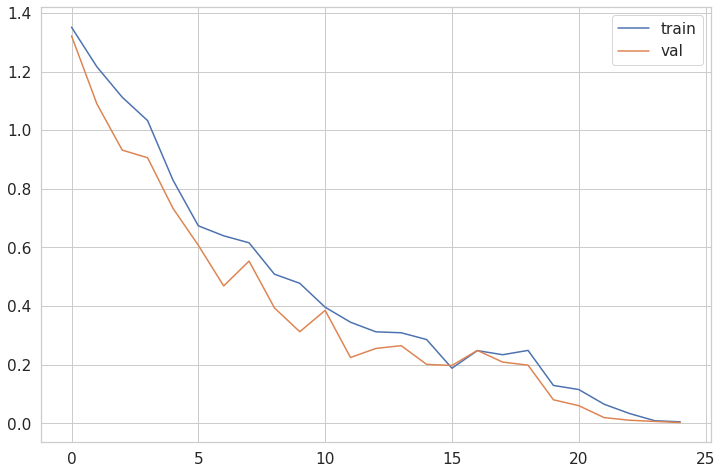

In [26]:
# Визуализируем train / val loss

plot_loss(losses_custom_cnn)

In [27]:
# Сохраним результат

torch.save(custom_cnn.state_dict(), '/content/custom_cnn.pth')

# **Результат**

In [29]:
# Проверим Accuracy для каждого класса

cls_scores_mob_netv3 = class_score(mob_netv3, testloader, train_set, DEVICE)
cls_scores_custom_cnn = class_score(custom_cnn, testloader, train_set, DEVICE)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [30]:
# Для Fine-tuned MobileNetV3-Small

cls_scores_mob_netv3

,Class,N,Accuracy
0,A,50,1.0
1,B,50,1.0
2,C,50,1.0
3,D,50,1.0


In [31]:
# Для Custom CNN

cls_scores_custom_cnn


,Class,N,Accuracy
0,A,50,1.0
1,B,50,1.0
2,C,50,1.0
3,D,50,1.0
